# Определение перспективного тарифа для телеком компании

Клиентам федерального оператора сотовой связи «Мегалайн» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## 1. Откроем файлы и изучим общую информацию

In [82]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt

In [83]:
calls=pd.read_csv('/datasets/calls.csv')
print(calls.info())
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Проверим какое количество звонков не состоялись

In [84]:
len(calls.query('duration==0'))

39613

In [85]:
calls=calls.query('duration!=0')

Таких звонков оказалось почти 20%. 
Предположим, что связь внезаппно оборвалась или абонент сбросил не дождавшись ответа. Такое бывает 

In [86]:
internet=pd.read_csv('/datasets/internet.csv')
print(internet.info())
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [87]:
messages=pd.read_csv('/datasets/messages.csv')
print(messages.info())
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [88]:
tariffs=pd.read_csv('/datasets/tariffs.csv')
print(tariffs.info())
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [89]:
users=pd.read_csv('/datasets/users.csv')
print(users.info())
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


В таблицах нет незаполненных ячеек (кроме столбца churn_date), но присутствуют колонки с датами которые можно привести к соответсвующему типу, атакже столбцы с вещественными значениями которые нужно округлить до целых.

## Шаг 2. Подготовим данные

В таблице calls отформатируем столбец с датой. Добавим столбец с номером месяца.
В столбце duration округлим значения вверх и сменим тип на целочисленный.

In [90]:
calls['call_date']=pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_month']=calls['call_date'].dt.month
calls['duration']=np.ceil(calls['duration']).astype('int')

В таблице internet отформатируем столбец с датой. Добавим столбец с номером месяца.
В столбце mb_used округлим значения вверх и сменим тип на целочисленный.

In [91]:
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_month']=internet['session_date'].dt.month
internet['mb_used']=np.ceil(internet['mb_used']).astype('int')

В таблице messages отформатируем столбец с датой. Добавим столбец с номером месяца

In [92]:
messages['message_date']=pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_month']=messages['message_date'].dt.month

В таблице users отформатируем столбец с датой. 

In [93]:
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Посчитаем данные для каждого пользователя

#### количество сделанных звонков и израсходованных минут разговора по месяцам

In [94]:
data_calls=calls.pivot_table(index =('user_id','call_month'), values='duration', aggfunc=('count','sum'))
data_calls.reset_index(inplace=True)

Добавим в таблицу уникальный столбец с id клиента и месяцем

In [95]:
data_calls['user-month']=data_calls['user_id'].astype(str)+'-'+data_calls['call_month'].astype(str)
data_calls.head()

,user_id,call_month,count,sum,user-month
0,1000,5,17,159,1000-5
1,1000,6,28,172,1000-6
2,1000,7,41,340,1000-7
3,1000,8,42,408,1000-8
4,1000,9,46,466,1000-9


Таблица с количеством звонков

In [96]:
data_calls.pivot_table(index ='user_id', columns='call_month', values='count')

call_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,17.0,28.0,41.0,42.0,46.0,44.0,37.0,38.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,47.0
1002,NaN,NaN,NaN,NaN,NaN,14.0,21.0,37.0,25.0,24.0,25.0,27.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,105.0,97.0,95.0,88.0
1004,NaN,NaN,NaN,NaN,7.0,25.0,20.0,18.0,18.0,21.0,15.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,95.0,126.0,112.0,120.0
1496,6.0,65.0,67.0,52.0,50.0,57.0,63.0,62.0,58.0,56.0,66.0,65.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,48.0,58.0


Таблица с продолжительностью звонков

In [97]:
data_calls.pivot_table(index ='user_id', columns='call_month', values='sum')

call_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0,813.0,1030.0,954.0,1031.0
1496,48.0,594.0,557.0,521.0,484.0,555.0,582.0,527.0,486.0,450.0,662.0,518.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.0,371.0,545.0


#### количество отправленных сообщений по месяцам

In [98]:
data_messages=messages.pivot_table(index =('user_id','message_month'), values='message_date', aggfunc='count')
data_messages.reset_index(inplace=True)

Добавим в таблицу уникальный столбец с id клиента и месяцем

In [99]:
data_messages['user-month']=data_messages['user_id'].astype(str)+'-'+data_messages['message_month'].astype(str)
data_messages.rename(columns={'message_date':'mes_count'}, inplace=True)
data_messages.rename(columns={'message_month':'mes_month'}, inplace=True)
data_messages.head()

,user_id,mes_month,mes_count,user-month
0,1000,5,22,1000-5
1,1000,6,60,1000-6
2,1000,7,75,1000-7
3,1000,8,81,1000-8
4,1000,9,57,1000-9


Таблица с количеством отправленных сообщений

In [100]:
data_messages.pivot_table(index ='user_id', columns='mes_month', values='mes_count')

mes_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,82.0,82.0,79.0,84.0
1496,9.0,45.0,46.0,49.0,40.0,35.0,42.0,41.0,29.0,35.0,46.0,51.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,14.0,17.0


#### объем израсходованного интернет-трафика по месяцам

In [101]:
data_internet=internet.pivot_table(index =('user_id','session_month'), values='mb_used', aggfunc=('sum'))
data_internet.reset_index(inplace=True)

Добавим в таблицу уникальный столбец с номер клиента и месяцем

In [102]:
data_internet['user-month']=data_internet['user_id'].astype(str)+'-'+data_internet['session_month'].astype(str)
data_internet.rename(columns={'session_month':'ses_month'}, inplace=True)
data_internet.head()

,user_id,ses_month,mb_used,user-month
0,1000,5,2256,1000-5
1,1000,6,23257,1000-6
2,1000,7,14016,1000-7
3,1000,8,14070,1000-8
4,1000,9,14581,1000-9


Таблица с интернет-трафиком

In [103]:
data_internet.pivot_table(index ='user_id', columns='ses_month', values='mb_used')

ses_month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0
1002,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0
1004,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2616.0,33105.0,29393.0,38972.0,23450.0
1496,3766.0,28523.0,24990.0,21098.0,23740.0,20163.0,24395.0,23560.0,26970.0,28215.0,25092.0,20757.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11512.0,14174.0,19940.0


#### Объединим таблицы data_calls и data_messages

In [104]:
data=data_calls.merge(data_messages, how='outer', on='user-month')
data=data.merge(data_internet, how='outer', on='user-month')
data.head()

,user_id_x,call_month,count,sum,user-month,user_id_y,mes_month,mes_count,user_id,ses_month,mb_used
0,1000.0,5.0,17.0,159.0,1000-5,1000.0,5.0,22.0,1000.0,5.0,2256.0
1,1000.0,6.0,28.0,172.0,1000-6,1000.0,6.0,60.0,1000.0,6.0,23257.0
2,1000.0,7.0,41.0,340.0,1000-7,1000.0,7.0,75.0,1000.0,7.0,14016.0
3,1000.0,8.0,42.0,408.0,1000-8,1000.0,8.0,81.0,1000.0,8.0,14070.0
4,1000.0,9.0,46.0,466.0,1000-9,1000.0,9.0,57.0,1000.0,9.0,14581.0


Удалим лишние столбцы

In [105]:
data=data.drop(['user_id_x','user_id_y','user_id','call_month','mes_month','ses_month'], axis='columns')  
data.head()

,count,sum,user-month,mes_count,mb_used
0,17.0,159.0,1000-5,22.0,2256.0
1,28.0,172.0,1000-6,60.0,23257.0
2,41.0,340.0,1000-7,75.0,14016.0
3,42.0,408.0,1000-8,81.0,14070.0
4,46.0,466.0,1000-9,57.0,14581.0


Разобьем столбец user-month на столбцы user_id и month

In [106]:
data['user_id']=data['user-month'].apply(lambda x: x.split('-')[0]).astype(int)
data['month']=data['user-month'].apply(lambda x: x.split('-')[1]).astype(int)
data.head()

,count,sum,user-month,mes_count,mb_used,user_id,month
0,17.0,159.0,1000-5,22.0,2256.0,1000,5
1,28.0,172.0,1000-6,60.0,23257.0,1000,6
2,41.0,340.0,1000-7,75.0,14016.0,1000,7
3,42.0,408.0,1000-8,81.0,14070.0,1000,8
4,46.0,466.0,1000-9,57.0,14581.0,1000,9


Добавим к таблице data данные из users. Удалим лишнее. Заменим  пропуски нулями 

In [107]:
data=data.merge(users, how='left', on='user_id')
data=data.drop(['age','churn_date','first_name','last_name','reg_date'], axis='columns')
data=data.fillna(0)
data.head()

,count,sum,user-month,mes_count,mb_used,user_id,month,city,tariff
0,17.0,159.0,1000-5,22.0,2256.0,1000,5,Краснодар,ultra
1,28.0,172.0,1000-6,60.0,23257.0,1000,6,Краснодар,ultra
2,41.0,340.0,1000-7,75.0,14016.0,1000,7,Краснодар,ultra
3,42.0,408.0,1000-8,81.0,14070.0,1000,8,Краснодар,ultra
4,46.0,466.0,1000-9,57.0,14581.0,1000,9,Краснодар,ultra


Заменим типы данных столбцов на целочисленные. Переименуем столбцы для удобства

In [108]:
data['count']=data['count'].astype(int)
data['sum']=data['sum'].astype(int)
data['mes_count']=data['mes_count'].astype(int)
data['mb_used']=data['mb_used'].astype(int)
data.rename(columns={'count':'call_count','sum':'call_sum' }, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
call_count    3214 non-null int64
call_sum      3214 non-null int64
user-month    3214 non-null object
mes_count     3214 non-null int64
mb_used       3214 non-null int64
user_id       3214 non-null int64
month         3214 non-null int64
city          3214 non-null object
tariff        3214 non-null object
dtypes: int64(6), object(3)
memory usage: 251.1+ KB


#### Узнаем помесячную выручку с каждого пользователя 

In [109]:
def dohod(row):
    if row['tariff']=='ultra':
        calls=row['call_sum']-500
        if calls<0:
            calls=0
        messages=row['mes_count']-50
        if messages<0:
            messages=0
        mbs=row['mb_used']-15360
        if mbs<0:
            mbs=0
        return 550+calls*3+messages*3+mbs*0.2
    else:
        calls=row['call_sum']-3000
        if calls<0:
            calls=0
        messages=row['mes_count']-1000
        if messages<0:
            messages=0
        mbs=row['mb_used']-30720
        if mbs<0:
            mbs=0
    return 1950 + calls*1 + messages*1 + mbs*0.15 

In [110]:
data['dohod']=data.apply(dohod, axis=1)
data.head()

,call_count,call_sum,user-month,mes_count,mb_used,user_id,month,city,tariff,dohod
0,17,159,1000-5,22,2256,1000,5,Краснодар,ultra,550.0
1,28,172,1000-6,60,23257,1000,6,Краснодар,ultra,2159.4
2,41,340,1000-7,75,14016,1000,7,Краснодар,ultra,625.0
3,42,408,1000-8,81,14070,1000,8,Краснодар,ultra,643.0
4,46,466,1000-9,57,14581,1000,9,Краснодар,ultra,571.0


In [111]:
data.pivot_table(index='user_id',columns ='month', values='dohod')

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,550.0,2159.4,625.0,643.0,571.0,619.0,574.0,610.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0
1002,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,2056.0,1714.0,1654.0,1531.0
1004,NaN,NaN,NaN,NaN,685.0,1253.8,2319.6,3502.4,838.0,1521.8,928.2,1421.6
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550.0,5134.0,5042.6,6721.4,3863.0
1496,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.0


## Шаг 3. Проанализируем данные

Создадим отдельную таблицу для каждого тарифа

In [112]:
data_ultra=data.query('tariff=="ultra"')

In [113]:
data_smart=data.query('tariff=="smart"')

Для дальнейшего удобства сравнения создадим две таблички куда будем заносить характеристики

In [114]:
ultra=pd.DataFrame({'call':[0,0,0], 'inet':[0,0,0], 'mess':[0,0,0],})

In [115]:
smart=pd.DataFrame({'call':[0,0,0], 'inet':[0,0,0], 'mess':[0,0,0],})

### Тариф Ультра

#### Сколько минут разговоривают пользователи

Посчитайте среднее количество

In [116]:
ultra.at[0,'call']=data_ultra['call_sum'].mean()
print(ultra.at[0,'call'])

526


Посчитайте  дисперсию 

In [117]:
ultra.at[1,'call']=np.var(data_ultra['call_sum'],ddof=1)
print(ultra.at[1,'call'])

100873


Стандартное отклонение

In [118]:
ultra.at[2,'call']=np.std(data_ultra['call_sum'],ddof=1)
print(ultra.at[2,'call'])

317


Гистограмма распределения

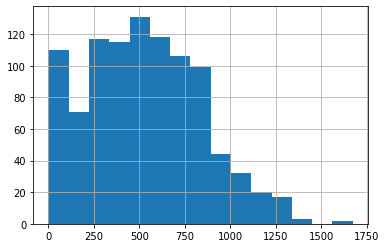

In [119]:
data_ultra['call_sum'].hist(bins=15)

#### Какой объём интернет-трафика используют

Посчитайте среднее количество

In [120]:
ultra.at[0,'inet']=data_ultra['mb_used'].mean()
print(ultra.at[0,'inet'])

19486


Посчитайте  дисперсию 

In [121]:
ultra.at[1,'inet']=np.var(data_ultra['mb_used'],ddof=1)
print(ultra.at[1,'inet'])

101935621


Стандартное отклонение

In [122]:
ultra.at[2,'inet']=np.std(data_ultra['mb_used'],ddof=1)
print(ultra.at[2,'inet'])

10096


Гистограмма распределения

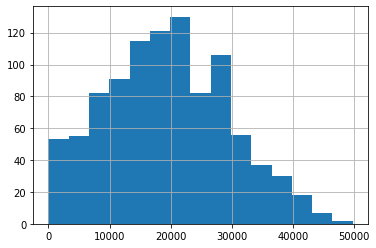

In [123]:
data_ultra['mb_used'].hist(bins=15)

#### Сколько сообщений отправляют

Посчитайте среднее количество

In [124]:
ultra.at[0,'mess']=data_ultra['mes_count'].mean()
print(ultra.at[0,'mess'])

49


Посчитайте  дисперсию 

In [125]:
ultra.at[1,'mess']=np.var(data_ultra['mes_count'],ddof=1)
print(ultra.at[1,'mess'])

2285


Стандартное отклонение

In [126]:
ultra.at[2,'mess']=np.std(data_ultra['mes_count'],ddof=1)
print(ultra.at[2,'mess'])

47


Гистограмма распределения

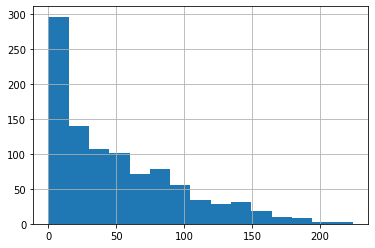

In [127]:
data_ultra['mes_count'].hist(bins=15)

### Тариф Смарт

#### Сколько минут разговоривают пользователи

Посчитайте среднее количество

In [128]:
smart.at[0,'call']=data_smart['call_sum'].mean()
print(smart.at[0,'call'])

417


Посчитайте  дисперсию 

In [129]:
smart.at[1,'call']=np.var(data_smart['call_sum'],ddof=1)
print(smart.at[1,'call'])

36219


Стандартное отклонение

In [130]:
smart.at[2,'call']=np.std(data_smart['call_sum'],ddof=1)
print(smart.at[2,'call'])

190


Гистограмма распределения

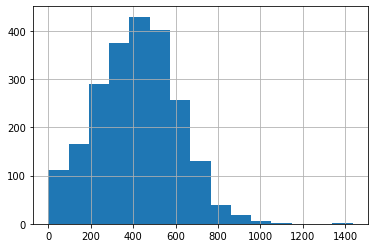

In [131]:
data_smart['call_sum'].hist(bins=15)

#### Какой объём интернет-трафика используют

Посчитайте среднее количество

In [132]:
smart.at[0,'inet']=data_smart['mb_used'].mean()
print(smart.at[0,'inet'])

16229


Посчитайте  дисперсию 

In [133]:
smart.at[1,'inet']=np.var(data_smart['mb_used'],ddof=1)
print(smart.at[1,'inet'])

34545911


Стандартное отклонение

In [134]:
smart.at[2,'inet']=np.std(data_smart['mb_used'],ddof=1)
print(smart.at[2,'inet'])

5877


Гистограмма распределения

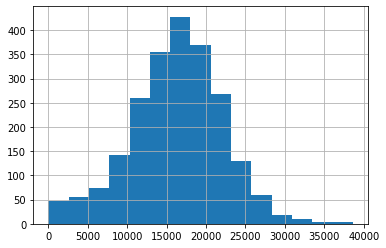

In [135]:
data_smart['mb_used'].hist(bins=15 )

#### Сколько сообщений отправляют

Посчитайте среднее количество

In [136]:
smart.at[0,'mess']=data_smart['mes_count'].mean()
print(smart.at[0,'mess'])

33


Посчитайте  дисперсию 

In [137]:
smart.at[1,'mess']=np.var(data_smart['mes_count'],ddof=1)
print(smart.at[1,'mess'])

796


Стандартное отклонение

In [138]:
smart.at[2,'mess']=np.std(data_smart['mes_count'],ddof=1)
print(smart.at[2,'mess'])

28


Гистограмма распределения

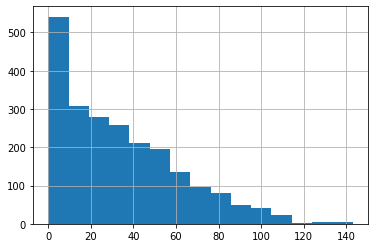

In [139]:
data_smart['mes_count'].hist(bins=15)

In [140]:
ultra= ultra.rename( index={0: 'mean',1: 'var',2: 'std' })
smart= smart.rename( index={0: 'mean',1: 'var',2: 'std' })

Сравним посчитанные значения для двух тарифов

In [141]:
len(data_ultra)

985

In [142]:
len(data_smart)

2229

In [143]:
ultra

,call,inet,mess
mean,526,19486,49
var,100873,101935621,2285
std,317,10096,47


In [144]:
smart

,call,inet,mess
mean,417,16229,33
var,36219,34545911,796
std,190,5877,28


#### Сравним посчитанные значения для двух тарифов

В тарифе Ультра гораздо выше дисперсия значений, а в тарифе Смарт большинство значений тяготеют к среднему. 
Возможно это связано с тем, что пользователей тарифа Смарт в 2 раза больше. 

## Шаг 4. Проверим гипотезы

#### Сравним доходы от двух тарифов

Сформулируем гипотезу H₀
- средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова

Альтернативная гипотеза H₁
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Сравнивать будем с помощью Т-теста по среднему значению выборок.
Пороговое значение alpha уровня значимости зададим равным:

In [145]:
alpha=0.05

In [146]:
results = st.ttest_ind(data_ultra['dohod'], data_smart['dohod'], equal_var = False)  # так как дисперсии сильно отличаются

In [147]:
print('p-значение: ', results.pvalue  )

if (results.pvalue  < alpha):
    print("Отвергаем гипотезу H₀. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается")
else:
    print("Принимаем гипотезу H₀. Средняя выручка пользователей тарифов «Ультра» и «Смарт» действительно одинакова")

p-значение:  1.4130233909462012e-11
Отвергаем гипотезу H₀. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


Для наглядности взглянем не среднее двух тарифных планов

In [148]:
print(data_ultra['dohod'].mean())

2325.962639593909


In [149]:
print(data_smart['dohod'].mean())

1953.486541049798


#### Сравним доходы от пользователей из Москвы и других регионов

Сформулируем гипотезу H₀
- доходы оператора в Москве и регионах одинаковы

Альтернативная гипотеза H₁
- доходы оператора в Москве и регионах отличаются

Сравнивать будем с помощью Т-теста по среднему значению выборок.
Пороговое значение alpha уровня значимости оставим равным:

In [150]:
alpha=0.05 

In [151]:
results = st.ttest_ind(data.query('city=="Москва"')['dohod'], data.query('city!="Москва"')['dohod']) 

In [152]:
print('p-значение: ', results.pvalue  )

if (results.pvalue  < alpha):
    print("Отвергаем гипотезу H₀. Доходы оператора в Москве и регионах отличаются")
else:
    print("Принимаем гипотезу H₀. Доходы оператора в Москве и регионах одинаковы")

p-значение:  0.00012237549664916622
Отвергаем гипотезу H₀. Доходы оператора в Москве и регионах отличаются


Для наглядности взглянем на средние доходы

In [153]:
print(data.query('city=="Москва"')['dohod'].mean())

2202.1067921440263


In [154]:
print(data.query('city!="Москва"')['dohod'].mean())

2036.076623127161


## Шаг 5. Выводы

В ходе исследования обнаружено: 
- пользователей тарифа Ультра в 2 раза меньше и дисперсия выборки гораздо выше по сравнению с тарифом Смарт
- тем не менее, выручка оператора на тарифе Ультра выше
- также выручка в Москве больше чем регионах